<a href="https://colab.research.google.com/github/revanthbethala/shoreline_extraction/blob/main/swin_lstm_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio -q
from google.colab import drive
# drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 120.1 MB/s eta 0:00:00


/tmp/ipython-input-2374315788.py:22: RuntimeWarning: invalid value encountered in subtract
  ndwi  = (green - nir) / (green + nir + eps)
/tmp/ipython-input-2374315788.py:23: RuntimeWarning: invalid value encountered in subtract
  mndwi = (green - swir) / (green + swir + eps)
/tmp/ipython-input-2374315788.py:24: RuntimeWarning: invalid value encountered in subtract
  awei  = 4 * (green - swir) - (0.25 * nir + 2.75 * swir)
/tmp/ipython-input-2374315788.py:62: RuntimeWarning: invalid value encountered in subtract
  (red   - red.min())   / (red.max()   - red.min()   + 1e-6),
/tmp/ipython-input-2374315788.py:62: RuntimeWarning: invalid value encountered in divide
  (red   - red.min())   / (red.max()   - red.min()   + 1e-6),
/tmp/ipython-input-2374315788.py:63: RuntimeWarning: invalid value encountered in subtract
  (green - green.min()) / (green.max() - green.min() + 1e-6),
/tmp/ipython-input-2374315788.py:63: RuntimeWarning: invalid value encountered in divide
  (green - green.min()) / (gr

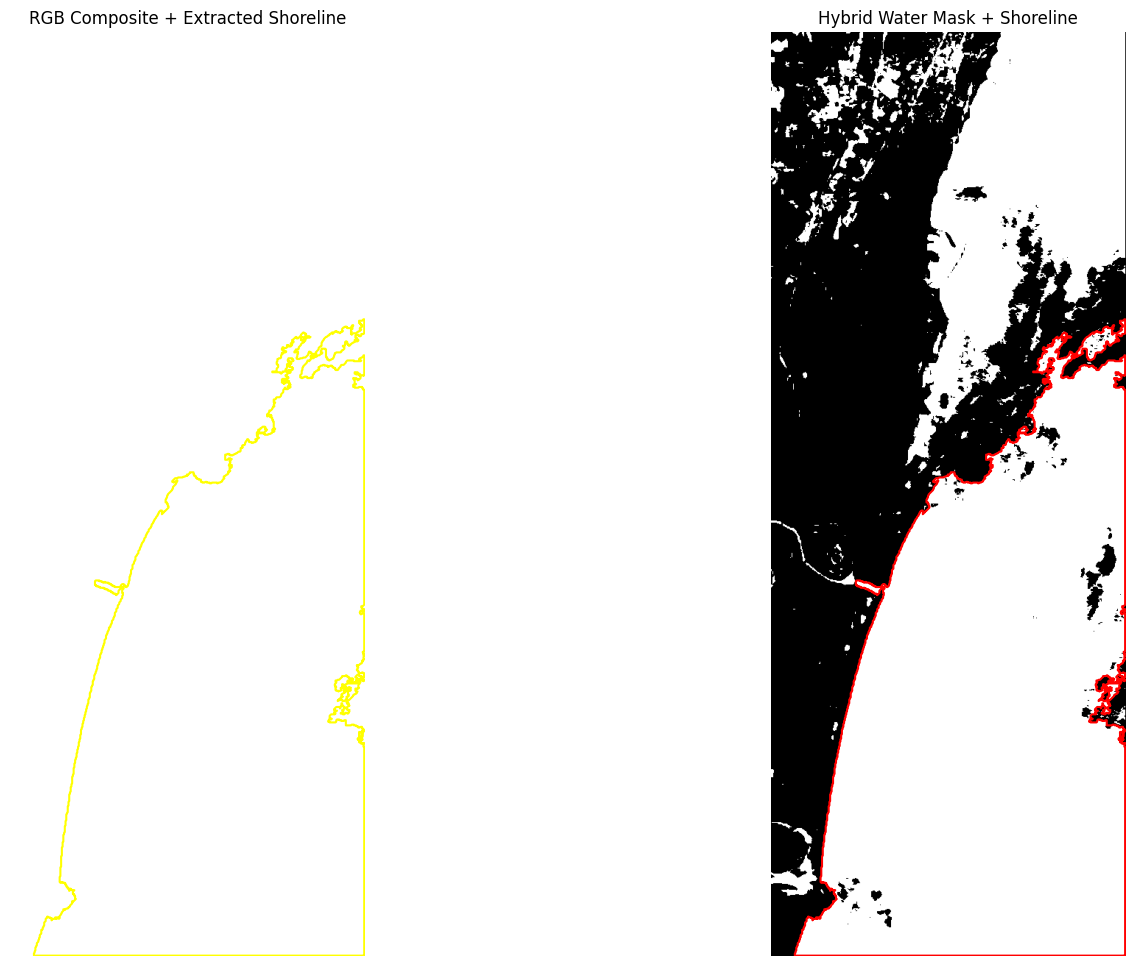

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from shapely.geometry import LineString

# ============================================================
# PUT YOUR extract_shoreline FUNCTION HERE
# ============================================================

def extract_shoreline(image_path):
    with rasterio.open(image_path) as src:
        blue  = src.read(1).astype("float32")
        green = src.read(2).astype("float32")
        red   = src.read(3).astype("float32")
        nir   = src.read(4).astype("float32")
        swir  = src.read(5).astype("float32")
        transform = src.transform

        eps = 1e-6

        ndwi  = (green - nir) / (green + nir + eps)
        mndwi = (green - swir) / (green + swir + eps)
        awei  = 4 * (green - swir) - (0.25 * nir + 2.75 * swir)

        water_votes = (
            (ndwi > 0.05).astype(int) +
            (mndwi > 0.05).astype(int) +
            (awei > 0).astype(int)
        )

        water_mask = (water_votes >= 2).astype("uint8")

        contours = measure.find_contours(water_mask, 0.5)
        if len(contours) == 0:
            return None, water_mask, transform

        largest = max(contours, key=len)
        xs, ys = rasterio.transform.xy(transform, largest[:,0], largest[:,1])
        shoreline = np.column_stack([xs, ys])

        return shoreline, water_mask, transform

# ============================================================
# 1) SELECT ONE SAMPLE TIF TO VISUALIZE
# ============================================================

SAMPLE_TIF = "/content/drive/MyDrive/coastsat_chennai/2022/2022-01-02-04-58-45_L8_chennai_ms.tif"  # <-- REPLACE THIS PATH

shoreline, water_mask, transform = extract_shoreline(SAMPLE_TIF)

with rasterio.open(SAMPLE_TIF) as src:
    red   = src.read(3).astype("float32")
    green = src.read(2).astype("float32")
    blue  = src.read(1).astype("float32")

# ============================================================
# 2) PREPARE RGB IMAGE FOR DISPLAY
# ============================================================

rgb = np.dstack([
    (red   - red.min())   / (red.max()   - red.min()   + 1e-6),
    (green - green.min()) / (green.max() - green.min() + 1e-6),
    (blue  - blue.min())  / (blue.max()  - blue.min()  + 1e-6),
])

# ============================================================
# 3) PLOT RESULTS
# ============================================================

plt.figure(figsize=(18, 12))

# ------------------- RGB + shoreline ------------------------
plt.subplot(1, 2, 1)
plt.title("RGB Composite + Extracted Shoreline")
plt.imshow(rgb)

if shoreline is not None:
    xs = shoreline[:,0]
    ys = shoreline[:,1]
    rows, cols = rasterio.transform.rowcol(transform, xs, ys)
    plt.plot(cols, rows, color='yellow', linewidth=1.5)

plt.axis("off")

# ------------------- Hybrid Water Mask + shoreline ----------
plt.subplot(1, 2, 2)
plt.title("Hybrid Water Mask + Shoreline")
plt.imshow(water_mask, cmap="gray")

if shoreline is not None:
    plt.plot(cols, rows, color='red', linewidth=1.5)

plt.axis("off")

plt.show()



In [ ]:
import os
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString, Point
from skimage import measure
from tqdm import tqdm

# ============================================================
# 1. SETTINGS
# ============================================================
ROOT = "/content/drive/MyDrive/coastsat_chennai"   # Year-wise folders
BASELINE = "/content/drive/MyDrive/chennai_baseline.geojson"

TRANSECT_SPACING = 200
TRANSECT_LENGTH = 2000
CUSTOM_YEARS = list(range(1990,2025))  # your custom years

# ============================================================
# 2. LOAD BASELINE AND REPROJECT TO TIF CRS
# ============================================================

# load baseline
baseline_gdf = gpd.read_file(BASELINE)

# find first tif to read CRS
first_tif = None
for root, dirs, files in os.walk(ROOT):
    for f in files:
        if f.lower().endswith(".tif"):
            first_tif = os.path.join(root, f)
            break
    if first_tif:
        break

with rasterio.open(first_tif) as src:
    tif_crs = src.crs

print("Baseline CRS:", baseline_gdf.crs)
print("TIF CRS:", tif_crs)

# reproject baseline to tif CRS
baseline_gdf = baseline_gdf.to_crs(tif_crs)
baseline = baseline_gdf.geometry.iloc[0]

# handle MultiLineString
if baseline.geom_type == "MultiLineString":
    baseline = LineString([pt for line in baseline for pt in line.coords])

# ============================================================
# 3. GENERATE TRANSECTS (now in correct CRS)
# ============================================================
def generate_transects(baseline, spacing=200, length=2000):
    transects = []
    distances = np.arange(0, baseline.length, spacing)

    for d in distances:
        p = baseline.interpolate(d)
        next_p = baseline.interpolate(min(d+1, baseline.length))

        x1, y1 = p.x, p.y
        x2, y2 = next_p.x, next_p.y

        dx = x2 - x1
        dy = y2 - y1

        nx, ny = -dy, dx
        n_len = (nx**2 + ny**2)**0.5
        nx /= n_len
        ny /= n_len

        p1 = (x1 - nx*(length/2), y1 - ny*(length/2))
        p2 = (x1 + nx*(length/2), y1 + ny*(length/2))

        transects.append(LineString([p1, p2]))

    return transects

transects = generate_transects(baseline, TRANSECT_SPACING, TRANSECT_LENGTH)

transects_gdf = gpd.GeoDataFrame(
    {"transect_id": range(len(transects)), "geometry": transects},
    crs=baseline_gdf.crs
)

# ============================================================
# 4. NDWI SHORELINE EXTRACTION (auto-detect Landsat type)
# ============================================================
def extract_shoreline(image_path):
    with rasterio.open(image_path) as src:
        blue  = src.read(1).astype("float32")
        green = src.read(2).astype("float32")
        red   = src.read(3).astype("float32")
        nir   = src.read(4).astype("float32")
        swir  = src.read(5).astype("float32")

        # Normalize to avoid division explosion
        eps = 1e-6

        # ---- NDWI ----
        ndwi = (green - nir) / (green + nir + eps)

        # ---- MNDWI ----
        mndwi = (green - swir) / (green + swir + eps)

        # ---- AWEI ---- (Xu, 2005)
        awei = 4 * (green - swir) - (0.25 * nir + 2.75 * swir)

        # ---- Combined Water Mask ----
        water = (
            (ndwi > 0.05).astype(int) +
            (mndwi > 0.05).astype(int) +
            (awei > 0).astype(int)
        )

        # Keep pixels detected by at least 2 methods → avoids over-detection
        water_mask = (water >= 2)

        # Clean mask
        water_mask = water_mask.astype("uint8")

        # Extract contours
        contours = measure.find_contours(water_mask, 0.5)
        if len(contours) == 0:
            return None

        largest = max(contours, key=len)

        xs, ys = rasterio.transform.xy(src.transform, largest[:,0], largest[:,1])

        return LineString(zip(xs, ys))

# ============================================================
# 5. COLLECT TIFS FROM CUSTOM YEARS
# ============================================================
all_tifs = []

for year in CUSTOM_YEARS:
    folder_path = os.path.join(ROOT, str(year))
    if not os.path.exists(folder_path):
        print("Missing:", folder_path)
        continue
    for f in os.listdir(folder_path):
        if f.lower().endswith(".tif"):
            all_tifs.append(os.path.join(folder_path, f))

print("Total images:", len(all_tifs))

# ============================================================
# 6. FIND INTERSECTIONS
# ============================================================
records = []

for path in tqdm(sorted(all_tifs)):
    fname = os.path.basename(path)
    shoreline = extract_shoreline(path)

    if shoreline is None:
        continue

    for t_id, transect in enumerate(transects):
        inter = shoreline.intersection(transect)
        if inter.is_empty:
            continue

        if inter.geom_type == "MultiPoint":
            pts = list(inter.geoms)
            dists = [transect.project(pt) for pt in pts]
            inter = pts[int(np.argmin(dists))]

        if inter.geom_type == "Point":
            records.append({
                "filename": fname,
                "filepath": path,
                "transect_id": t_id,
                "x": inter.x,
                "y": inter.y
            })

# ============================================================
# 7. SAVE OUTPUT
# ============================================================
out_gdf = gpd.GeoDataFrame(
    records,
    geometry=gpd.points_from_xy([r["x"] for r in records], [r["y"] for r in records]),
    crs=tif_crs
)

out_gdf.to_file("shoreline_intersections.gpkg", driver="GPKG")
out_gdf.to_csv("shoreline_intersections.csv", index=False)

print("DONE")
print("Saved shoreline_intersections.gpkg and shoreline_intersections.csv")


Baseline CRS: EPSG:4326
TIF CRS: EPSG:32644
Total images: 608


 11%|█         | 64/608 [00:24<06:27,  1.40it/s]/tmp/ipython-input-3440121087.py:101: RuntimeWarning: invalid value encountered in subtract
  ndwi = (green - nir) / (green + nir + eps)
/tmp/ipython-input-3440121087.py:104: RuntimeWarning: invalid value encountered in subtract
  mndwi = (green - swir) / (green + swir + eps)
/tmp/ipython-input-3440121087.py:107: RuntimeWarning: invalid value encountered in subtract
  awei = 4 * (green - swir) - (0.25 * nir + 2.75 * swir)
 16%|█▌        | 95/608 [00:47<04:36,  1.86it/s]/tmp/ipython-input-3440121087.py:104: RuntimeWarning: invalid value encountered in divide
  mndwi = (green - swir) / (green + swir + eps)
 16%|█▌        | 96/608 [00:49<06:33,  1.30it/s]/tmp/ipython-input-3440121087.py:101: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (green + nir + eps)
 24%|██▍       | 148/608 [01:24<07:39,  1.00it/s]/tmp/ipython-input-3440121087.py:101: RuntimeWarning: invalid value encountered in subtract
  ndwi = (green 

DONE
Saved shoreline_intersections.gpkg and shoreline_intersections.csv


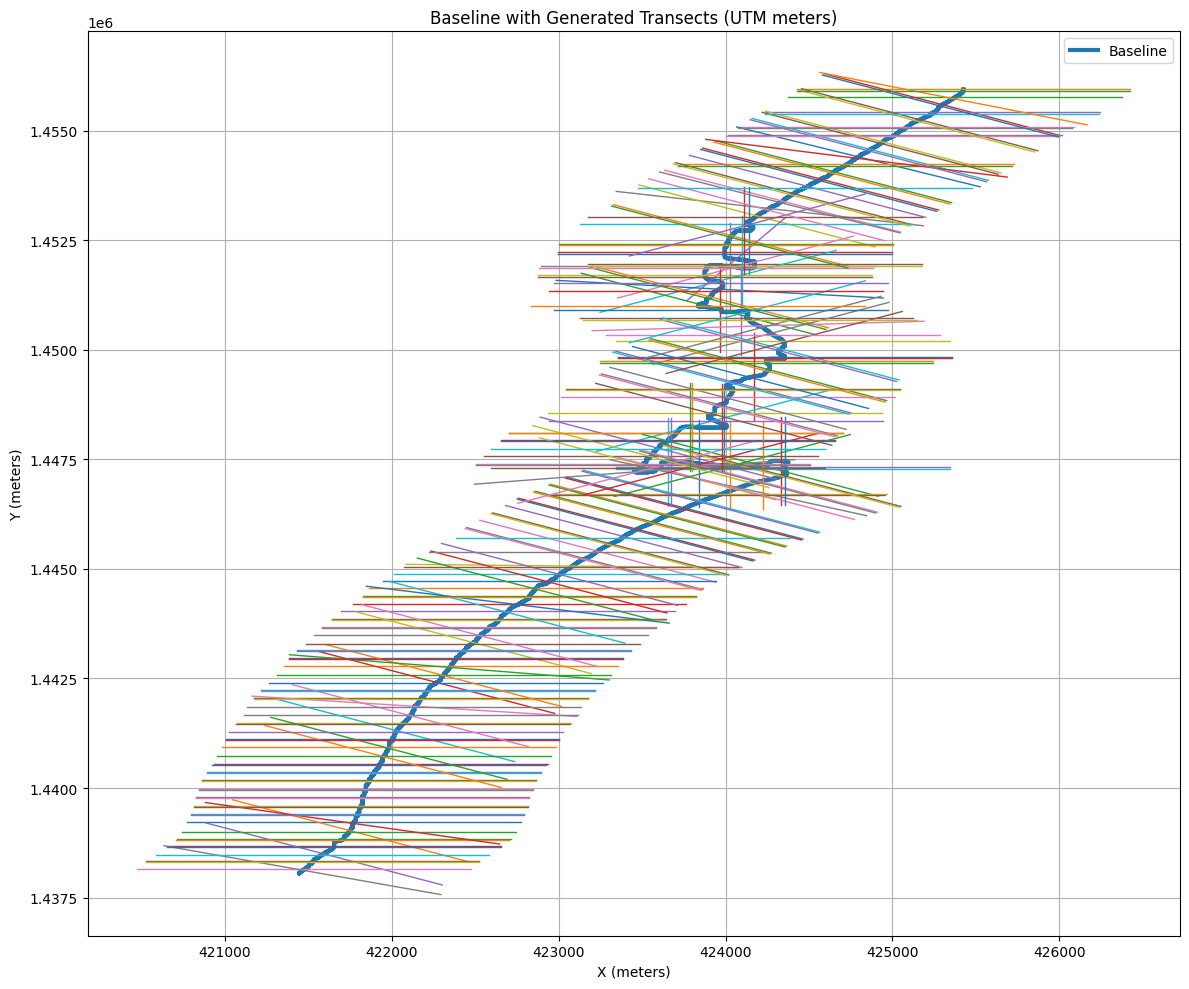

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from shapely.geometry import LineString
import os

# ================================
# Paths
# ================================
ROOT = "/content/drive/MyDrive/coastsat_chennai"
BASELINE = "/content/drive/MyDrive/chennai_baseline.geojson"
TRANSECT_SPACING = 200
TRANSECT_LENGTH = 2000

# ================================
# Load baseline
# ================================
baseline_gdf = gpd.read_file(BASELINE)
baseline = baseline_gdf.geometry.iloc[0]

# Find first TIF to get CRS
first_tif = None
for root, dirs, files in os.walk(ROOT):
    for f in files:
        if f.lower().endswith(".tif"):
            first_tif = os.path.join(root, f)
            break
    if first_tif:
        break

with rasterio.open(first_tif) as src:
    tif_crs = src.crs

# Reproject baseline to TIF CRS
baseline_gdf = baseline_gdf.to_crs(tif_crs)
baseline = baseline_gdf.geometry.iloc[0]

# If multi-part geometry, make it single LineString
if baseline.geom_type == "MultiLineString":
    baseline = LineString([pt for line in baseline for pt in line.coords])

# ================================
# Generate transects
# ================================
def generate_transects(baseline, spacing=200, length=2000):
    transects = []
    distances = np.arange(0, baseline.length, spacing)

    for d in distances:
        p = baseline.interpolate(d)
        next_p = baseline.interpolate(min(d + 1, baseline.length))

        x1, y1 = p.x, p.y
        x2, y2 = next_p.x, next_p.y

        dx = x2 - x1
        dy = y2 - y1

        # Normal vector
        nx, ny = -dy, dx
        n_len = np.sqrt(nx**2 + ny**2)
        nx /= n_len
        ny /= n_len

        # Create transect
        p1 = (x1 - nx * (length/2), y1 - ny * (length/2))
        p2 = (x1 + nx * (length/2), y1 + ny * (length/2))

        transects.append(LineString([p1, p2]))

    return transects

transects = generate_transects(baseline, TRANSECT_SPACING, TRANSECT_LENGTH)

# ================================
# Plot baseline + transects
# ================================
plt.figure(figsize=(12,10))

# Plot baseline
x, y = baseline.xy
plt.plot(x, y, linewidth=3, label="Baseline")

# Plot transects
for i, t in enumerate(transects):
    xt, yt = t.xy
    plt.plot(xt, yt, linewidth=1)

plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title("Baseline with Generated Transects (UTM meters)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


DONE — Saved /content/shoreline_intersections_with_dist.csv
year
1990.0          NaN
1991.0     0.801935
1992.0     0.711187
1993.0   -14.916352
1994.0    11.162358
1995.0    -0.792685
1996.0     7.428068
1997.0   -13.520352
1998.0     7.500501
1999.0    11.677790
2000.0    -7.075793
2001.0    -5.246417
2002.0     3.783877
2003.0   -21.852368
2004.0     7.969547
2005.0     2.097510
2006.0     1.995169
2007.0    -8.896221
2008.0   -20.046027
2009.0     1.764130
2010.0    -7.109387
2011.0     4.402479
2012.0    -5.358250
2013.0     0.012505
2014.0     1.921794
2015.0    -0.426614
2016.0    -9.106190
2017.0     2.195396
2018.0    -0.882021
2019.0    -1.530279
2020.0     2.825044
2021.0    -5.013746
2022.0     3.019635
2023.0    -0.400622
2024.0    -8.074620
Name: dist_m, dtype: float64


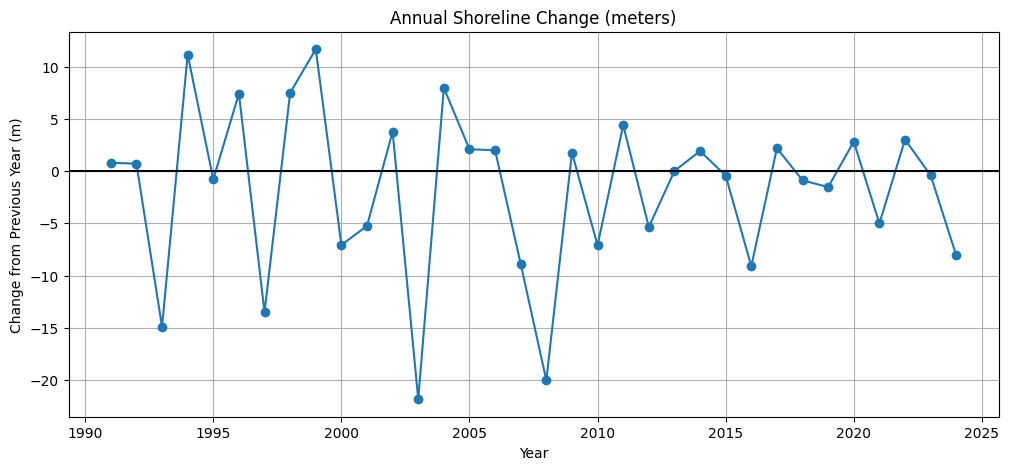

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import os
from shapely.geometry import LineString, Point

# ============================================================
# Load existing intersection CSV
# ============================================================
df = pd.read_csv("/content/shoreline_intersections.csv")
df["year"] = df["filename"].str.extract(r'(^\d{4})').astype(float)
df = df.dropna(subset=["x","y","year"])

# ============================================================
# Rebuild transects (same as before)
# ============================================================
ROOT = "/content/drive/MyDrive/coastsat_chennai"
BASELINE = "/content/drive/MyDrive/chennai_baseline.geojson"
TRANSECT_SPACING = 200
TRANSECT_LENGTH = 2000

baseline_gdf = gpd.read_file(BASELINE)

# detect TIF CRS
first_tif = None
for root, dirs, files in os.walk(ROOT):
    for f in files:
        if f.lower().endswith(".tif"):
            first_tif = os.path.join(root, f)
            break
    if first_tif: break

with rasterio.open(first_tif) as src:
    tif_crs = src.crs

baseline_gdf = baseline_gdf.to_crs(tif_crs)
baseline = baseline_gdf.geometry.iloc[0]

if baseline.geom_type == "MultiLineString":
    baseline = LineString([pt for line in baseline for pt in line.coords])

# The generate_transects function is already defined in a previous cell,
# so it is not redefined here.
# It is expected to be imported or available in the global scope.
transects = generate_transects(baseline, TRANSECT_SPACING, TRANSECT_LENGTH)
transect_map = {i: t for i, t in enumerate(transects)}

# ============================================================
# Compute TRUE distance in meters along transect
# ============================================================
distances = []
for idx, r in df.iterrows():
    t_id = int(r["transect_id"])
    pt = Point(r["x"], r["y"])
    line = transect_map[t_id]
    dist = line.project(pt)       # meters
    distances.append(dist)

df["dist_m"] = distances

# Save updated CSV
df.to_csv("/content/shoreline_intersections_with_dist.csv", index=False)

print("DONE \u2014 Saved /content/shoreline_intersections_with_dist.csv")
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/shoreline_intersections_with_dist.csv")

# yearwise mean
year_mean = df.groupby("year")["dist_m"].mean().sort_index()

# diff gives annual change
annual_change = year_mean.diff()

print(annual_change)

plt.figure(figsize=(12,5))
plt.plot(annual_change.index, annual_change.values, marker="o")
plt.axhline(0, color="black")
plt.grid(True)
plt.title("Annual Shoreline Change (meters)")
plt.xlabel("Year")
plt.ylabel("Change from Previous Year (m)")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

# ============================================================
# STEP 1 — LOAD DATA + BUILD TIME SERIES (year × transect)
# ============================================================

df = pd.read_csv("/content/shoreline_intersections_with_dist.csv")

# Ensure required fields exist
df = df.dropna(subset=["year", "transect_id", "dist_m"])

# Create pivot: year as rows, transects as columns
pivot = df.pivot_table(
    index="year",
    columns="transect_id",
    values="dist_m",
    aggfunc="mean"   # multiple points in same year if exist
).sort_index()

print("Initial pivot shape:", pivot.shape)
print(pivot.head())

# Save raw time-series (optional)
pivot.to_csv("/content/shoreline_timeseries_raw.csv")

# ============================================================
# STEP 2 — HANDLE MISSING YEARS (interpolation)
# ============================================================

# Interpolate missing values between years
pivot_interp = pivot.interpolate(method="linear", limit_direction="both")

# Forward-fill & backward-fill if edges are missing
pivot_interp = pivot_interp.ffill().bfill()

print("\nAfter interpolation:")
print(pivot_interp.head())

# Save interpolated dataset
pivot_interp.to_csv("/content/shoreline_timeseries_interpolated.csv")

# ============================================================
# STEP 3 — NORMALIZE / SCALE THE DATA (MinMaxScaler)
# ============================================================

scaler = MinMaxScaler()
scaled = scaler.fit_transform(pivot_interp)

# Convert back to DataFrame (same shape)
scaled_df = pd.DataFrame(
    scaled,
    index=pivot_interp.index,
    columns=pivot_interp.columns
)

print("\nScaled dataset preview:")
print(scaled_df.head())

# Save scaled dataset + scaler
scaled_df.to_csv("/content/shoreline_timeseries_scaled.csv")
joblib.dump(scaler, "/content/shoreline_scaler.pkl")

print("\nDONE — Created:")
print("/content/shoreline_timeseries_raw.csv")
print("/content/shoreline_timeseries_interpolated.csv")
print("/content/shoreline_timeseries_scaled.csv")
print("/content/shoreline_scaler.pkl")


Initial pivot shape: (35, 232)
transect_id       0           1           2           3           4    \
year                                                                    
1990.0       997.5000  988.210678  996.152237  990.000000  980.554564   
1991.0       990.9375  969.954004  981.646217  988.014610  975.961558   
1992.0       993.7500  971.605339  982.946023  988.676407  975.929969   
1993.0       985.5000  964.210678  978.308351  985.235065  975.005051   
1994.0       990.0000  963.491262  976.810877  983.235209  974.840909   

transect_id         5           6           7           8           9    ...  \
year                                                                     ...   
1990.0       988.332611  992.327561  987.035354  990.969337  985.371835  ...   
1991.0       982.083153  980.872835  982.027192  987.135733  980.424617  ...   
1992.0       978.055435  975.718374  978.590038  982.879615  982.958042  ...   
1993.0       966.666089  955.465512  966.058262  976.2351

In [ ]:
import pandas as pd
import numpy as np
import torch

# Load scaled time-series (year × transect)
scaled_df = pd.read_csv("/content/shoreline_timeseries_scaled.csv", index_col=0)

data = scaled_df.values      # shape: (years, transects)
years = scaled_df.index

WINDOW = 10   # number of past years to use
X = []
y = []
year_targets = []

for i in range(len(data) - WINDOW):
    X.append(data[i:i+WINDOW])
    y.append(data[i+WINDOW])          # the next year's shoreline
    year_targets.append(years[i+WINDOW])

X = np.array(X)   # shape: (samples, window, transects)
y = np.array(y)   # shape: (samples, transects)
year_targets = np.array(year_targets)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Convert to torch tensors
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)
import torch
import torch.nn as nn

class SwinSpatialEncoder(nn.Module):
    def __init__(self, num_transects, embed_dim=64, num_heads=4):
        super().__init__()

        self.embedding = nn.Linear(1, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim*4,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

    def forward(self, x):
        # x shape: (batch, window, transects)
        B, W, T = x.shape

        # reshape so each transect is a token
        x = x.view(B*W, T, 1)

        x = self.embedding(x)      # → (B*W, T, embed_dim)
        x = self.transformer(x)    # → (B*W, T, embed_dim)

        x = x.view(B, W, T, -1)
        return x
class SwinLSTMModel(nn.Module):
    def __init__(self, num_transects, embed_dim=64, num_heads=4, lstm_hidden=128):
        super().__init__()

        self.swin = SwinSpatialEncoder(num_transects, embed_dim, num_heads)

        # LSTM expects: (batch, window, feature_dim)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=lstm_hidden,
            num_layers=4,
            batch_first=True
        )

        # Final dense layer predicts next year's shoreline for all transects
        self.fc = nn.Linear(lstm_hidden, num_transects)

    def forward(self, x):
        # x: (batch, window, transects)

        # 1. Swin spatial encoding
        s = self.swin(x)   # → (batch, window, transects, embed_dim)

        # 2. Mean-pool spatial tokens for each year
        s = s.mean(dim=2)  # → (batch, window, embed_dim)

        # 3. LSTM temporal encoding
        _, (h, _) = self.lstm(s)

        h_last = h[-1]     # final LSTM hidden state

        # 4. Predict next-year shoreline distances
        y = self.fc(h_last)

        return y
num_transects = scaled_df.shape[1]

model = SwinLSTMModel(num_transects=num_transects)
print(model)


X shape: (25, 10, 232)
y shape: (25, 232)
SwinLSTMModel(
  (swin): SwinSpatialEncoder(
    (embedding): Linear(in_features=1, out_features=64, bias=True)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (lstm): LSTM(64, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=232, b

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# Device setup (GPU if available)
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================================
# Your data (X_torch, y_torch already created)
# Shapes:
# X_torch = (samples, window, transects)
# y_torch = (samples, transects)
# ============================================================

# Train/Test split (80/20)
split = int(0.8 * len(X_torch))

X_train = X_torch[:split]
y_train = y_torch[:split]

X_val = X_torch[split:]
y_val = y_torch[split:]

print("Train samples:", len(X_train))
print("Val samples:", len(X_val))

# Create Dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=4, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=4, shuffle=False)

# ============================================================
# Initialize model on GPU/CPU
# ============================================================
num_transects = X_torch.shape[2]
model = SwinLSTMModel(num_transects=num_transects).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# LR scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=10,
)

# ============================================================
# Training Loop
# ============================================================
EPOCHS = 200
train_losses = []
val_losses = []

for epoch in range(EPOCHS):

    # ---- TRAIN ----
    model.train()
    running_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ---- VALIDATION ----
    model.eval()
    val_loss_total = 0.0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            val_loss_total += loss.item()

    val_loss = val_loss_total / len(val_loader)
    val_losses.append(val_loss)

    # Update LR scheduler
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

# ============================================================
# Save trained model
# ============================================================
torch.save(model.state_dict(), "/content/swin_lstm.pth")
print("Model saved to /content/swin_lstm.pth")

# ============================================================
# Plot Loss Curve
# ============================================================
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Swin-LSTM Training Loss")
plt.legend()
plt.grid(True)
plt.show()


New dataset: (6264, 8, 1) (6264, 1)
Train samples: 5011
Val samples: 1253
Epoch 1/80 | Train 0.065998 | Val 0.048502
Epoch 2/80 | Train 0.058215 | Val 0.057004
Epoch 3/80 | Train 0.058141 | Val 0.047617
Epoch 4/80 | Train 0.057433 | Val 0.048611
Epoch 5/80 | Train 0.057361 | Val 0.048578
Epoch 6/80 | Train 0.056556 | Val 0.048587
Epoch 7/80 | Train 0.056409 | Val 0.049546
Epoch 8/80 | Train 0.056418 | Val 0.049308
Epoch 9/80 | Train 0.056455 | Val 0.050765
Epoch 10/80 | Train 0.056571 | Val 0.049522
Epoch 11/80 | Train 0.056203 | Val 0.049900
Epoch 12/80 | Train 0.056180 | Val 0.049655
Epoch 13/80 | Train 0.056640 | Val 0.049345
Epoch 14/80 | Train 0.056375 | Val 0.051170
Epoch 15/80 | Train 0.056255 | Val 0.049979
Epoch 16/80 | Train 0.056294 | Val 0.049272
Epoch 17/80 | Train 0.056268 | Val 0.049322
Epoch 18/80 | Train 0.056054 | Val 0.051710
Epoch 19/80 | Train 0.056184 | Val 0.048921
Epoch 20/80 | Train 0.056123 | Val 0.050276
Epoch 21/80 | Train 0.056111 | Val 0.049508
Epoch 22/80

In [ ]:
import torch
import pandas as pd
import numpy as np
import joblib

# =============================================
# Load model + scaler + scaled dataset
# =============================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_transects = X_torch.shape[2]

model = SwinLSTMModel(num_transects=num_transects).to(device)
model.load_state_dict(torch.load("/content/swin_lstm.pth", map_location=device))
model.eval()

print("Model loaded.")

# Load scaler
scaler = joblib.load("/content/shoreline_scaler.pkl")

# Load scaled dataset (up to 2005)
scaled_df = pd.read_csv("/content/shoreline_timeseries_scaled.csv", index_col=0)

years = scaled_df.index.values
data = scaled_df.values

WINDOW = 5

# =============================================
# Predict year-by-year (2006 onward)
# =============================================

pred_years = []
pred_scaled = []

for i in range(len(data) - WINDOW):
    input_seq = data[i:i+WINDOW]             # shape: (5, 232)
    input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_next = model(input_seq).cpu().numpy().flatten()

    year_predicted = years[i+WINDOW]
    pred_years.append(year_predicted)
    pred_scaled.append(pred_next)

pred_scaled = np.array(pred_scaled)

print("Predicted years:", pred_years)
print("Predicted shape:", pred_scaled.shape)

# =============================================
# Convert predictions back to meters
# =============================================
pred_meters = scaler.inverse_transform(pred_scaled)

print("\nPredicted shoreline distances (meters):")
print(pred_meters)

# Save predictions
np.save("/content/predicted_shoreline_scaled.npy", pred_scaled)
np.save("/content/predicted_shoreline_meters.npy", pred_meters)

print("\nSaved predicted_shoreline_meters.npy")


Model loaded.
Predicted years: [np.float64(1995.0), np.float64(1996.0), np.float64(1997.0), np.float64(1998.0), np.float64(1999.0), np.float64(2000.0), np.float64(2001.0), np.float64(2002.0), np.float64(2003.0), np.float64(2004.0), np.float64(2005.0), np.float64(2006.0), np.float64(2007.0), np.float64(2008.0), np.float64(2009.0), np.float64(2010.0), np.float64(2011.0), np.float64(2012.0), np.float64(2013.0), np.float64(2014.0), np.float64(2015.0), np.float64(2016.0), np.float64(2017.0), np.float64(2018.0), np.float64(2019.0), np.float64(2020.0), np.float64(2021.0), np.float64(2022.0), np.float64(2023.0), np.float64(2024.0)]
Predicted shape: (30, 232)

Predicted shoreline distances (meters):
[[977.7517  946.1835  960.31836 ... 947.67975 985.90924 941.7263 ]
 [977.75183 946.1841  960.3187  ... 947.6817  985.911   941.7291 ]
 [977.751   946.182   960.31683 ... 947.67285 985.905   941.7183 ]
 ...
 [977.7518  946.18475 960.31683 ... 947.6806  985.911   941.732  ]
 [977.7504  946.18146 960.3

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load actual shoreline data (meters, interpolated)
actual_df = pd.read_csv("/content/shoreline_timeseries_interpolated.csv", index_col=0)

# Load predicted shoreline data (meters)
pred_meters = np.load("/content/predicted_shoreline_meters.npy")

# Determine the number of predicted years
num_pred_years = pred_meters.shape[0]

# Based on your shapes (30, 232), the prediction covers 30 years.
# Assuming the 30 years are 1995-2024 (as per previous context):
pred_years = list(range(1995, 1995 + num_pred_years))

# Extract only actual data rows corresponding to the predicted years
actual_matrix = actual_df.loc[pred_years].values

# --- COMPUTE METRICS ---

# Flatten all transects & years → global error
actual_flat = actual_matrix.flatten()
pred_flat  = pred_meters.flatten()

# Both actual_flat and pred_flat now have shape (6960,)

rmse = np.sqrt(mean_squared_error(actual_flat, pred_flat))
mae  = mean_absolute_error(actual_flat, pred_flat)

# FIX: Use actual_flat and pred_flat for MAPE calculation
mape = np.mean(np.abs((actual_flat - pred_flat) / (actual_flat + 1e-6))) * 100

r2 = r2_score(actual_flat, pred_flat)

print("===== SHORELINE MODEL ACCURACY =====")
print(f"RMSE  : {rmse:.2f} meters")
print(f"MAE   : {mae:.2f} meters")
print(f"MAPE  : {mape:.2f}%")
print(f"R^2   : {r2:.4f}")

# Per-transect RMSE (must use 2D arrays)
# Note: For this, the arrays must be pred_meters and actual_matrix, not the flattened ones.
per_transect_rmse = np.sqrt(np.mean((actual_matrix - pred_meters)**2, axis=0))
np.save("/content/per_transect_rmse.npy", per_transect_rmse)
print("\nSaved per-transect RMSE to /content/per_transect_rmse.npy")

===== SHORELINE MODEL ACCURACY =====
RMSE  : 120.46 meters
MAE   : 67.92 meters
MAPE  : 11.64%
R^2   : 0.7264

Saved per-transect RMSE to /content/per_transect_rmse.npy
